In [124]:
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_context('paper')

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [125]:
df = pd.read_pickle("data/lbc_pandas.pkl")

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [127]:
rmr_params={'n_estimators':[10,50,100],
            'max_features':range(1,6),
            'min_samples_split':[2,4]}

In [128]:
grid = GridSearchCV(RandomForestRegressor(oob_score=True),cv=3,param_grid=rmr_params)

In [59]:
careof = ['Surface','Arrondissement','Meuble_int','weekday','ins_hour','Ges_int','ClasseEnergie_int']
ylbl   = ['LoyerMensuel',]
z = df[careof+ylbl].dropna()
x = z[careof]
y = z[ylbl[0]]

In [52]:
_=grid.fit(x,y);

In [53]:
rmr = grid.best_estimator_
print grid.best_params_
print grid.best_score_

{'max_features': 2, 'min_samples_split': 4, 'n_estimators': 100}
0.417221700623


In [60]:
print cross_val_score(rmr,x,y).mean()
# rmr.fit(x,y)
features_importance = { n:y for n,y in zip(careof,rmr.feature_importances_)}
ymax = np.sum(features_importance.values())

for k,v in features_importance.iteritems():
    print "{0:20s}| {1:5.1f}%".format(k,v/ymax*100)


0.417630854525
Arrondissement      |  21.0%
Surface             |  41.0%
ins_hour            |  12.1%
weekday             |   5.9%
Meuble_int          |   4.5%
ClasseEnergie_int   |   8.7%
Ges_int             |   6.7%


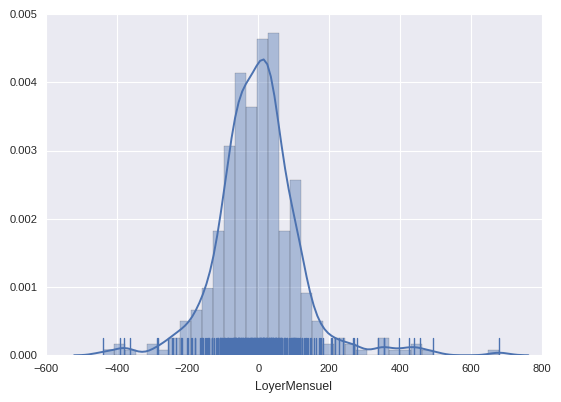

In [129]:
sns.distplot(y-rmr.predict(x),rug=1)

In [106]:
def forecastFeatureDynamics(g,rows=24,field=4):
    x=g.values
#     print x
#     return 0
    egys=[]
    field = 4
    for i in range(len(x))[:10]:
        eg = x[i].copy()
        h0 = int(eg[field])
        cols = eg.shape[0]
        eg = np.tile(eg,rows).reshape(rows,cols)
        eg[:,field]=np.arange(0,rows)
        egy = rmr.predict(eg)
        eg0 = egy[h0]
    #     print egy/eg0
        egys.append(egy/eg0)
    #     sns.plt.plot(eg[:,4],egy/eg0,'-')
    one = np.mean(egys,axis=0)
    two = np.std(egys,ddof=1,axis=0)/len(egys)**.5
    return {'h_':np.arange(0,24), 'mean_':one,'std_':two}
pex = x.groupby('Arrondissement').apply(forecastFeatureDynamics)

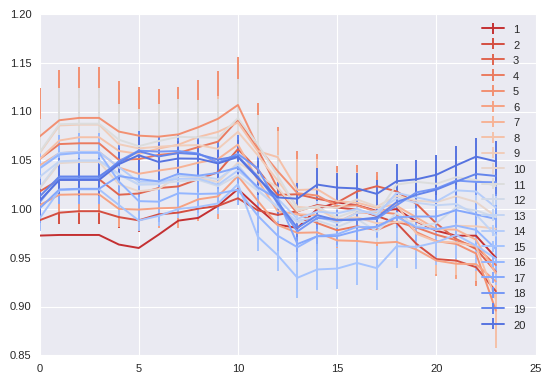

In [130]:
palette = (i for i in sns.color_palette('coolwarm_r',21))
for k,v in pex.to_dict().iteritems():
    _x=v['h_']
    _y=v['mean_']
    _ye=v['std_']

    sns.plt.errorbar(_x,_y,yerr=_ye,label='{0:d}'.format(k),color=palette.next())
sns.plt.legend(loc=1,)